In [429]:
import numpy as np 
import  pandas as pd 
import matplotlib.pyplot as plt
import  re
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from ydata_profiling import ProfileReport

In [430]:
%matplotlib notebook

# load dataset

In [431]:
df = pd.read_csv('Datasets/log.csv')

In [432]:
df.head()

,ip,timestamp,http_method,url_path,status_code,response_length,user_agent,response_time
0,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,/cdn/profiles/1026106239,304,0,Googlebot-Image/1.0,32
1,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,images/badge.png,304,0,Googlebot-Image/1.0,4
2,35.110.222.153,2021-5-12T5:6:0.0+0430,Get,/pages/630180847,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32
3,35.108.208.99,2021-5-12T5:6:0.0+0430,Get,images/fav_icon2.ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20
4,35.110.222.153,2021-5-12T5:6:0.0+0430,Get,images/sanjagh_logo_purpule5.png,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8


In [433]:
df.shape

(1240227, 8)

In [434]:
df.columns.tolist()

['ip',
 'timestamp',
 'http_method',
 'url_path',
 'status_code',
 'response_length',
 'user_agent',
 'response_time']

In [435]:
df.isnull().sum()

ip                 0
timestamp          0
http_method        0
url_path           0
status_code        0
response_length    0
user_agent         0
response_time      0
dtype: int64

In [436]:
df.duplicated().sum()

16627

In [437]:
df = df.drop_duplicates(keep='first').reset_index(drop=True)

In [438]:
def value_checker(column):
    print( f'{column} values are {df[column].dtype}' if df[column].isin(['','-',' ']).sum() == 0 else f'{column} values are\'nt normal')

    
value_checker('ip')
value_checker('response_length')
value_checker('response_time')

ip values are object
response_length values are int64
response_time values are int64


---
<span style="font-size: 2.5em;">F</span>or this step trough EDA we want first get profile report of dataset then take proper action beside one hot encoding or extract more features

---

In [ ]:
profile = ProfileReport(df, title='sanjagh log')
profile.to_file('report.html')

the report.html availabe in /report.html we start by **log transform column by column** on df but before that we save copy of df in org_df

In [439]:
org_df = df.copy()

**our base features are `ip`, `timestamp`, `http_method`, `url_path`, `status_code`, `response_lenght`, `user_agent` and `response_time`.**
 
 
 ---
- we can extract meaningfull feature from `ip` column independently like geographic location and subnet analysis but we dont do that due to wide usage of vpn in our country due to filtering policies. at the part of extracting features from several features we use ip properly with consideration other features 



- we extract crawling potential rate by using Tehran-X dataset Packets/Second in different hours of daytime, gives a weight to each request. It is highly crawler in hours like 6 a.m.

In [440]:
tehran_traffic = pd.read_csv('Datasets/TEHRAN-IX_Public_Traffic_Statistics.csv')

In [441]:
tehran_traffic

,Time,Packets
0,-11.75,119.396163
1,-11.50,121.076007
2,-11.25,122.994047
3,-11.00,124.848081
4,-10.75,126.463429
...,...,...
90,10.75,108.628655
91,11.00,111.541040
92,11.25,113.692382
93,11.50,116.178671


In [442]:
tehran_traffic.shape

(95, 2)

In [443]:
tehran_traffic.columns.tolist()

['Time', 'Packets']

In [444]:
tehran_traffic.dtypes

Time       float64
Packets    float64
dtype: object

In [445]:
tehran_traffic['Time'] = tehran_traffic['Time'].apply(lambda x: -1*round(x,2)+12)

In [446]:
tehran_traffic.describe()

,Time,Packets
count,95.000000,95.000000
mean,12.000000,101.147680
std,6.892024,33.812354
min,0.250000,34.537436
25%,6.125000,76.284281
50%,12.000000,113.797108
75%,17.875000,127.558180
max,23.750000,136.726324


<IPython.core.display.Javascript object>


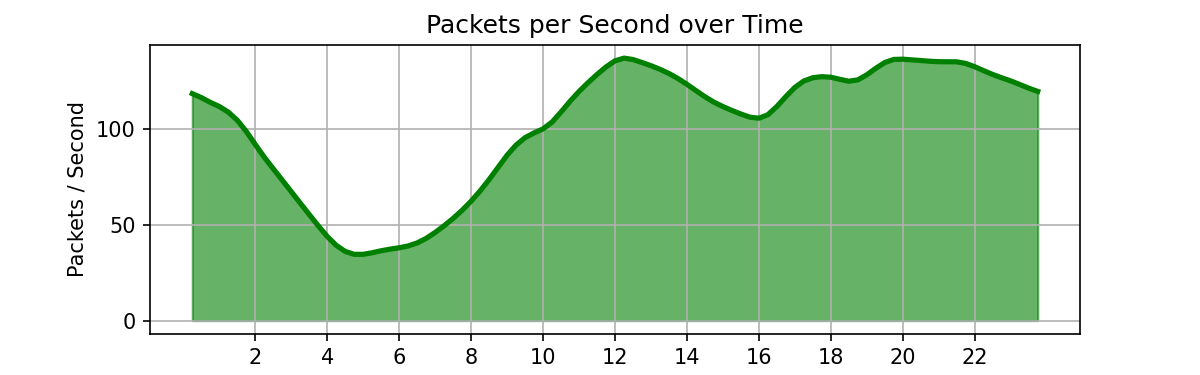

In [447]:
plt.figure(figsize=(8, 2.5))
plt.fill_between(tehran_traffic['Time'], tehran_traffic['Packets'], color='green', alpha=0.6)
plt.plot(tehran_traffic['Time'], tehran_traffic['Packets'], color='green', linewidth=2.5)

# Formatting the plot
plt.xlabel('Time')
plt.ylabel('Packets / Second')
plt.title('Packets per Second over Time')

# Set x-axis ticks
plt.xticks(tehran_traffic['Time'][7::8])

plt.grid(True)
plt.show()


In [449]:
tehran_traffic['Packets'] = MinMaxScaler().fit_transform(tehran_traffic[['Packets']])

In [450]:
tehran_traffic

,Time,Packets
0,23.75,0.830411
1,23.50,0.846849
2,23.25,0.865619
3,23.00,0.883762
4,22.75,0.899569
...,...,...
90,1.25,0.725042
91,1.00,0.753542
92,0.75,0.774594
93,0.50,0.798925


In [451]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
gmt_offset = df['timestamp'].dt.strftime('%z')

# Filter records with GMT offset different than +0430
filtered_df = df[gmt_offset != '+0430']

In [452]:
len(filtered_df)

0

now we can use tehran_traffic becuase all have same UTC

In [453]:
df['time'] = df['timestamp'].dt.hour + df['timestamp'].dt.minute / 60

In [454]:
df['time'] = np.round(df['time'] * 4) / 4

In [455]:
# Merge df with tehran_traffic based on matching timestamps
df = pd.merge(df, tehran_traffic, left_on='time', right_on='Time')

# Create a new column 'crawled_rate' in df and assign the corresponding 'Packet' values
df['crawled_rate'] = 1-df['Packets']

# Drop unnecessary columns
df.drop(['time', 'Time', 'Packets'], axis=1, inplace=True)

---
- we extract some feature corresponding to `http_method` 
>- **is_head**: usually normal user doesn't send such request and it Indicates a web crawler.


In [456]:
df['Head_request'] = np.where(df['http_method'] == 'Head', 1, 0)

---
- we extract some feature corresponding to `url_path` 
>- **url_depht**: Deeper URLs probably belong to a normal use
>- we have a wordlist in utils that is set of high-probability words that a malicious URL are contained and high penalty for them
>- we extract somem categorical features lie image, video, font, endpoint and etc from URL paths
---

The dataset doesnt contain any sql injection and the list doesn't contain sql injection words like `insert` and etc and also other type of url to extend wordlist.

In [457]:
suspicious_url_words = { 'robot.txt':1.5, 'api':.2, '404':.3, 'admin':2, 'login':2, 'backup':1.2,'include':.8,'agent':.2}

In [458]:
def suspicious_word_rate(url):
    rate = 0
    for word, count in suspicious_url_words.items():
        rate += url.count(word) * count
    return rate

df['url_anomaly_rate'] = df['url_path'].apply(suspicious_word_rate)

In [459]:
def get_url_path_depth(url_path):
    # Remove trailing slash if present
    url_path = url_path.rstrip('/')
    path_parts = url_path.split('/')
    depth = len(path_parts) - 1 
    return depth


df['url_path_depth'] = df['url_path'].apply(get_url_path_depth)

In [460]:
def has_extension(file_path, extensions):
    file_extension = file_path.split('?')[0].split('.')[-1].lower()
    return file_extension in extensions


In [461]:
image_extensions = ['png', 'jpg', 'jpeg', 'ico', 'gif', 'svg']
df['image_request'] = df['url_path'].apply(lambda x: has_extension(x,image_extensions)).astype(np.uint8)

In [462]:
code_extensions = ['js','css', 'xml','php']
df['code_request'] = df['url_path'].apply(lambda x: has_extension(x,code_extensions)).astype(np.uint8)

In [463]:
renderable_extensions =['html', 'json', 'txt']
df['renderable_request'] = df['url_path'].apply(lambda x: has_extension(x,renderable_extensions)).astype(np.uint8)

In [464]:
video_extensions = ['mp4', 'mov', 'wmv', 'avi', 'flw', 'swf']
df['video_requests'] = df['url_path'].apply(lambda x: has_extension(x,video_extensions)).astype(np.uint8)

In [465]:
font_extensions = ['woff2','woff','ttf','eot']
df['font_request'] = df['url_path'].apply(lambda x: has_extension(x,font_extensions)).astype(np.uint8)

In [466]:
font_extensions = ['apk']
df['app_request'] = df['url_path'].apply(lambda x: has_extension(x,font_extensions)).astype(np.uint8)

---
- we extract some feature corresponding to `status_code` 
>- **4xx**: `4xx` Client Error Codes are usually for bot, crawler or attackers.
    >- **301 and 302 and 307 and 308**: `301` or `308` (Moved Permanently) and `302` or `307` (Found) are usually response are suspicious due to URL manipulation tactics, Unresolved temporary redirects, Redirection loops and Extensive scraping activity.
---


In [467]:
df['4xx'] = np.where(df['status_code']//100 == 4, 5, 0)

In [468]:
df['3xx'] = np.where(df['status_code'].isin([301, 302, 307, 308]), 1, 0)

---
- we extract some feature corresponding to `response_time` and `response_length` 
    >- **category**: Add a feature named response time/length category with corresponding to `np.geomspace`.
---


In [469]:
list(np.geomspace(1, df['response_length'].max(), num=6))

[1.0,
 39.98698708282836,
 1598.9591359622816,
 63937.55831569421,
 2556670.318477246,
 102233543.0]

In [470]:
response_length_bins = [-1, 40, 1599, 63938, 2556670, 102233543]
df['response_length_bin'] = pd.cut(df['response_length'], bins=response_length_bins, labels = [0,1,2,3,4]).astype(np.uint8)

In [471]:
list(np.geomspace(1, df['response_time'].max(), num=6))

[1.0,
 44.527771079476494,
 1982.722397306263,
 88286.20902140415,
 3931188.1047798945,
 175047044.0]

In [472]:
response_length_bins = [-1, 45, 1983, 88286, 3931188, 175047044]
df['response_time_bin'] = pd.cut(df['response_time'], bins=response_length_bins, labels = [0,1,2,3,4]).astype(np.uint8)

---
- In this step we groupby our data based on `IP`, `USER_AGENT` and then extract other features and compute sum of these features per distinct tuple of (ip, user_agent). note that we can also do the above in one step but for more readibility we done it in 2 steps.
---
**but before we check df.dtypes to be sure about applying .mean() on it without error**

In [477]:
df.dtypes

ip                                                    object
timestamp              datetime64[ns, pytz.FixedOffset(270)]
http_method                                           object
url_path                                              object
status_code                                            int64
response_length                                        int64
user_agent                                            object
response_time                                          int64
crawled_rate                                         float64
Head_request                                           int32
url_anomaly_rate                                     float64
url_path_depth                                         int64
image_request                                          uint8
code_request                                           uint8
renderable_request                                     uint8
video_requests                                         uint8
font_request            

In [481]:
grouped = df.groupby(['ip', 'user_agent'])

# Create a new DataFrame with desired columns
user_df = pd.DataFrame({
    'ip': [key[0] for key in grouped.groups.keys()],
    'user_agent': [key[1] for key in grouped.groups.keys()],
    'request_count': grouped.size().values
})

In [482]:
# Compute averages and standard deviations
avg_cols = ['crawled_rate', 'Head_request', 'url_anomaly_rate', 'url_path_depth', 
            'image_request', 'code_request', 'renderable_request', 'video_requests', 
            'font_request', 'app_request', '4xx', '3xx','response_length_bin', 'response_time_bin',
            'response_length', 'response_time']


# Add average columns
for col_name in avg_cols:
    user_df[f'{col_name}_avg'] = grouped[col_name].mean().values


In [483]:
std_cols = ['response_length_bin', 'response_time_bin']

# Add standard deviation columns
for col_name in std_cols:
    user_df[f'{col_name}_std'] = grouped[col_name].std().values


- some std columns has np.NaN value becuase for this (ip,user_agent) pair we have only 1 record. we dont worry about them becuase in worst cases we set a threshold for request_count and drop records less than this threshold at the end. ( there are not anomaly with just 1 request)

but here is not worse case, in log transform of the cols it handeled 

### <mark>**its for the version before computing bins for it and now its redundant**</mark>

In [484]:
# sqrt_transform_cols = ['response_lenght_std','response_time_std']


# for col_name in sqrt_transform_cols:
#     user_df[col_name] = user_df[col_name].apply(lambda x: math.sqrt(x))

In [485]:
# log_transform_cols = ['response_lenght_avg','response_time_avg']


# def log_transform(value):
#     if np.isnan(value):
#         value = 0
#     return np.log(1 + value)


# for col_name in log_transform_cols:
#     user_df[col_name] = user_df[col_name].apply(lambda x: log_transform(x))

In [486]:
user_df

,ip,user_agent,request_count,crawled_rate_avg,Head_request_avg,url_anomaly_rate_avg,url_path_depth_avg,image_request_avg,code_request_avg,renderable_request_avg,...,font_request_avg,app_request_avg,4xx_avg,3xx_avg,response_length_bin_avg,response_time_bin_avg,response_length_avg,response_time_avg,response_length_bin_std,response_time_bin_std
0,1.56.57.214,Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like M...,1,0.992092,0.0,0.000000,3.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,3.000000,0.000000,79149.000000,28.000000,NaN,NaN
1,1.66.71.34,Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like...,1,0.220229,0.0,0.000000,3.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,59156.000000,28.000000,NaN,NaN
2,1.81.122.235,Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like M...,7,0.083377,0.0,0.000000,3.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,3.000000,0.428571,108702.714286,41.714286,0.000000,0.534522
3,10.92.2.8,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,28,0.381179,0.0,0.000000,2.035714,0.285714,0.142857,0.0,...,0.071429,0.000000,0.000000,0.0,2.035714,0.107143,48159.571429,25.428571,0.576204,0.314970
4,100.92.35.41,Mozilla/5.0 (Linux; Android 9; SM-A205F) Apple...,12,0.044946,0.0,0.100000,2.416667,0.000000,0.333333,0.0,...,0.083333,0.000000,0.000000,0.0,1.833333,0.083333,100601.416667,26.333333,1.193416,0.288675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51068,99.239.78.14,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,14,0.038611,0.0,0.000000,1.142857,0.357143,0.357143,0.0,...,0.214286,0.000000,0.000000,0.0,0.142857,0.000000,3760.214286,7.428571,0.534522,0.000000
51069,99.239.78.14,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,22,0.000000,0.0,0.000000,1.363636,0.454545,0.227273,0.0,...,0.136364,0.000000,0.000000,0.0,2.090909,0.000000,43417.409091,9.272727,0.426401,0.000000
51070,99.239.78.14,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,21,0.078497,0.0,0.000000,1.285714,0.476190,0.238095,0.0,...,0.142857,0.000000,0.000000,0.0,2.095238,0.000000,44512.190476,8.380952,0.436436,0.000000
51071,99.239.97.147,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:8...,226,0.082757,0.0,0.051327,2.146018,0.269912,0.132743,0.0,...,0.039823,0.004425,0.044248,0.0,1.353982,0.035398,158990.159292,24.601770,0.942058,0.185194


### <mark>**for this version we fillna np.nan**</mark>

In [487]:
user_df['response_length_bin_std'] = user_df['response_length_bin_std'].fillna(0)

In [488]:
user_df['response_time_bin_std'] = user_df['response_time_bin_std'].fillna(0)

---
- we extract some feature corresponding to `user_agent` 
>- **is bot**: `IS BOT` indicates user agent is a bot or not
---


In [489]:
bot_name = ['bot', 'crawl', 'spider', 'slurp', 'Scrap', 'Sogou ', 'ia_archiver', 'Python-urllib']
def is_bot(user_agent):
    return any(bot_keyword in user_agent.lower() for bot_keyword in bot_name)
 

user_df['is_bot'] = user_df['user_agent'].apply(is_bot).astype(np.uint8)

In [490]:
user_priority = user_df['request_count'] * (1 + 10*user_df['is_bot'])

In [491]:
for threshold in range(21):
    if threshold < 11:
        tr = threshold
        
    elif threshold > 11:
        tr = threshold+20
    
    else : 
        tr = threshold +20
        print('.\n.\n.')
            
    remaining_records = user_df[user_priority > tr].shape[0]
    print(f'threshold={tr} - remaining records = {remaining_records}')

threshold=0 - remaining records = 51073
threshold=1 - remaining records = 41226
threshold=2 - remaining records = 35458
threshold=3 - remaining records = 33525
threshold=4 - remaining records = 31453
threshold=5 - remaining records = 30061
threshold=6 - remaining records = 29156
threshold=7 - remaining records = 28367
threshold=8 - remaining records = 27641
threshold=9 - remaining records = 27076
threshold=10 - remaining records = 26453
.
.
.
threshold=31 - remaining records = 7424
threshold=32 - remaining records = 7107
threshold=33 - remaining records = 6822
threshold=34 - remaining records = 6596
threshold=35 - remaining records = 6376
threshold=36 - remaining records = 6183
threshold=37 - remaining records = 6013
threshold=38 - remaining records = 5878
threshold=39 - remaining records = 5750
threshold=40 - remaining records = 5618


we set our `THRESHOLD`= 4 once and another time `THRESHOLD`= 40 to and train our models for them seprately. also we dont reset index each for tracibility of  results after fitting the model

In [550]:
user_df_31k = user_df[user_df['request_count'] > 3]
user_df_5k = user_df[user_df['request_count'] > 40]

for clustering ( here anomaly detection and some how clustering into two clusters, inlier and outlier, we use normalization( mean=0, std=1) for data scaling))

In [551]:
cols_to_normalize = list(set(user_df_31k.columns) - set(['ip', 'user_agent']))

user_df_31k_normalized = user_df_31k.copy()
user_df_31k_normalized[cols_to_normalize] = StandardScaler().fit_transform(user_df_31k[cols_to_normalize])
user_df_31k_normalized.reset_index(inplace=True)

In [552]:
user_df_31k_normalized.columns

Index(['index', 'ip', 'user_agent', 'request_count', 'crawled_rate_avg',
       'Head_request_avg', 'url_anomaly_rate_avg', 'url_path_depth_avg',
       'image_request_avg', 'code_request_avg', 'renderable_request_avg',
       'video_requests_avg', 'font_request_avg', 'app_request_avg', '4xx_avg',
       '3xx_avg', 'response_length_bin_avg', 'response_time_bin_avg',
       'response_length_avg', 'response_time_avg', 'response_length_bin_std',
       'response_time_bin_std', 'is_bot'],
      dtype='object')

* last but not least assign some important weight to our feature based on the problem criteria

In [553]:
feature_weights = {
    'request_count': 1.8,
    'crawled_rate_avg': 1.3,
    'Head_request_avg': 1.6,
    'url_anomaly_rate_avg': 2,
    'url_path_depth_avg': 1.0,
    'image_request_avg': 1.3,
    'code_request_avg': 1.1,
    'font_request_avg': 0.9,
    'app_request_avg' : 0.95,
    '4xx_avg': 1.8,
    '3xx_avg': 1.3,
    'response_length_bin_avg': 1.6,
    'response_time_bin_avg': 1.6,
    'response_length_avg': 1.3,
    'response_time_avg': 1.3,
    'response_length_bin_std': 1.2,
    'response_time_bin_std': 1.2,
    'is_bot': 2.2
}



for feature, weight in feature_weights.items():
    user_df_31k_normalized[feature] = user_df_31k_normalized[feature] * weight

In [554]:
user_df_31k.to_csv('Datasets/user_df_31k.csv', index=False)
user_df_31k_normalized.to_csv('Datasets/user_df_31k_normalized.csv', index=False)

# what we see next: 

---

## 1.BASE MODELS

>### 1-1. IF  (IsolationForest)
>### 1-2. PCA (PrincipalComponentAnalysis)

## 2.Advanced MODELS

>### 2-1. AE  (AutoEncoder)
>### 2-2. VAE (VariationalAutoEncoder)  <mark> if previous models are not good enough</mark>

